<a id='toc'></a>
# Improve the Model

1. [Setting up the Environment](#envir)
1. [Loading Training Set](#load)
1. [Predictive Modelling Function](#function)
1. [Principal Component Analysis](#pca)
1. [Most Important Attributes from Random Forest](#important)
1. [Creating New Ratio Attributes](#ratio)
1. [Testing Performance with New Ratio Attributes](#ratio_test)
    1. [Logistic Regression](#test_lr)
    1. [Random Forest](#test_rf)
    1. [AdaBoost](#test_ada)
    1. [Summary of Results](#summary)
    1. [Testing for Significant Difference in Results](#signif)
1. [Building an Ensemble Voting Classifier Model](#ensemble)
    1. [Ensemble - Soft Voting](#soft)
    1. [Ensemble - Hard Voting](#hard)
    1. [Summary Results with Ensemble Models](#ensemble_summary)

<a id='envir'></a>
# 1. Setting up the Environment

[Return](#toc)

In [7]:
import numpy as np
import pandas as pd
from numpy import nan as NaN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
#import os
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
#%matplotlib inline

<a id='load'></a>
# 2. Loading Training Set

[Return](#toc)

In [2]:
# Read in the data
path = 'C:/Users/X/Documents/A_Documents/Cap_Data/CSV'
train_set = pd.read_csv(path + '/train_test_sets/train_set_std.csv')
train_labels = pd.read_csv(path + '/train_test_sets/train_labels.csv')

In [3]:
train_set.shape

(215257, 259)

<a id='function'></a>
# 3. Predictive Modelling Function

[Return](#toc)

In [4]:
# A function to perform cross validation 
# with three different choices of sampling method
# The ROC curve plot has been commented out below. Not required here.

def classify_folds(clr, train_x, train_y, sample_method, folds):
    
    # Lists to store metrics
    aucs=[]
    recall=[]
    precision=[]
    f1score=[]
    accuracy=[]

    # Create the random under & over samplers
    rus = RandomUnderSampler(random_state=777)
    smote = SMOTE(ratio='minority', random_state=777, n_jobs=-1)

    # Create the folds
    splits = KFold(n_splits=folds).split(train_x, train_y)

    #fig = plt.figure(figsize=(8,6))
    i=0
    
    # Iterate through the folds
    for train_fold, test_fold in splits:
        # Depending on choice of sampling method - execute sampling
        if sample_method == 'under':
            sampled_x, sampled_y = rus.fit_sample(train_x[train_fold], train_y[train_fold])
        elif sample_method == 'over':
            sampled_x, sampled_y = smote.fit_sample(train_x[train_fold], train_y[train_fold])
        elif sample_method == 'none':
            sampled_x, sampled_y = train_x[train_fold], train_y[train_fold]            
        else:
            print('Incorrect Sample Input')
            return
    
        # Train the classifier on the sampled data
        clr.fit(sampled_x, sampled_y)
    
        # Test the classifier on the test fold (which is not sampled and remains imbalanced)
        probs = clr.predict_proba(train_x[test_fold])
        predict = clr.predict(train_x[test_fold])
        
        # Return arrays containing the fpr (x-axis), tpr (y-axis) and thresholds
        fpr, tpr, thresholds = roc_curve(train_y[test_fold], probs[:, 1])
    
        # Compute area under ROC curve
        roc_auc = auc(fpr, tpr)
    
        # Plot ROC curve
        #plt.plot(fpr, tpr, lw=1, alpha=0.8, label='Fold %d (AUC = %0.2f)' % (i, roc_auc))
    
        # Generate confusion matrix, compute measures and store
        matrix = confusion_matrix(train_y[test_fold], predict)
        TP = matrix[1,1]
        TN = matrix[0,0]
        FP = matrix[0,1]
        FN = matrix[1,0]
        rec = TP/(TP+FN)
        prec = TP/(TP+FP)
        f1 = 2*prec*rec/(prec+rec)
        acc = (TP+TN) /(TP+TN+FP+FN)
    
        aucs.append(roc_auc)
        recall.append(rec)
        precision.append(prec)
        f1score.append(f1)
        accuracy.append(acc)
        print(i,end="")
        i += 1
    
    #plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    #plt.xlabel('False Positive Rate', fontsize=15)
    #plt.ylabel('True Positive Rate', fontsize=15)
    #plt.title('ROC Curves', fontsize=15)
    #plt.legend(loc='lower right'); 

    # Dataframes to return results
    matrix = pd.DataFrame(matrix)
    matrix.index.name = 'Actual'; matrix.columns.name = 'Predicted'
    results = pd.DataFrame({'ROC_AUC':aucs, 'Recall':recall, 'Precision':precision, 'F1-Score':f1score, 'Accuracy':accuracy})
    mean = results.mean(); mean.name = 'Mean'
    #return results.append(mean), fig, matrix
    return results.append(mean), matrix

<a id='pca'></a>
# 4. Principal Component Analysis
Let's examine if PCA can help our model.

[Return](#toc)

In [5]:
pca=PCA()
train_pca = pca.fit_transform(train_set)

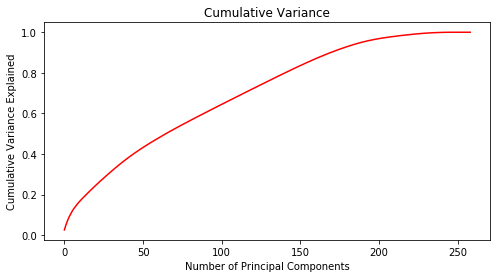

In [6]:
# Plot the cumulative variance explained
plt.figure(figsize = (8, 4))
plt.plot(list(range(train_pca.shape[1])), np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance');

It would seem that PCA is unlikely to help. Pretty much all PCs are still required to explain the majority of the variance.

Based on the chart above, about 175 PCs will give most of the variance. Let's train Random Forest on only 175 PCs.

In [7]:
# Can PCA improve Random Forest? Training on the first 175 PCs only
clr = RandomForestClassifier(max_depth=10, max_features=32, min_samples_leaf=10, n_estimators=500, n_jobs=-1, random_state=777)
metrics, matrix = classify_folds(clr, np.array(train_pca[:,0:174]), np.array(train_labels), 'under', 10)

print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

0123456789
Confusion matrix from last fold:

Predicted      0     1
Actual                
0          13040  6741
1            631  1113

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.711207  0.648180   0.143736  0.235294  0.661200
1     0.717320  0.670540   0.147835  0.242259  0.664638
2     0.716176  0.659065   0.149373  0.243548  0.666403
3     0.734660  0.675454   0.151114  0.246974  0.673372
4     0.705716  0.642369   0.142749  0.233589  0.656137
5     0.716283  0.640024   0.143179  0.234008  0.671235
6     0.708912  0.641615   0.150309  0.243560  0.669888
7     0.717894  0.650589   0.148890  0.242323  0.662997
8     0.712290  0.651258   0.145092  0.237313  0.667642
9     0.703083  0.638188   0.141711  0.231923  0.657515
Mean  0.714354  0.651728   0.146399  0.239079  0.665103


PCA is not helping here. Pretty much all PCs are still required to explain the majority of variance and results from the Random Forest model are slightly worse compared to using the full native attribute set.

<a id='important'></a>
# 5. Most Important Attributes from Random Forest

[Return](#toc)

In [10]:
# Training Random Forest on the full native attribute set to determine most 
# important attributes
clr = RandomForestClassifier(max_depth=10, max_features=32, min_samples_leaf=10, n_estimators=500, n_jobs=-1, random_state=777)
metrics, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'under', 10)

print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

0123456789
Confusion matrix from last fold:

Predicted      0     1
Actual                
0          13470  6311
1            579  1165

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.740336  0.668400   0.154370  0.250813  0.678900
1     0.746974  0.672284   0.156775  0.254258  0.684707
2     0.741800  0.668187   0.161144  0.259665  0.689538
3     0.757511  0.704159   0.160889  0.261931  0.685311
4     0.746742  0.687358   0.159910  0.259458  0.679922
5     0.750831  0.686205   0.159994  0.259487  0.692697
6     0.744032  0.687605   0.160261  0.259939  0.675695
7     0.744544  0.693775   0.162336  0.263108  0.678095
8     0.745513  0.685781   0.159217  0.258434  0.687526
9     0.731389  0.668005   0.155832  0.252711  0.679907
Mean  0.744967  0.682176   0.159073  0.257980  0.683230


In [11]:
RF_importances = pd.Series(clr.feature_importances_)
RF_importances.index = train_set.columns
important_summary = RF_importances.sort_values(ascending=False)[0:20]
print('Top 20 most important features from Random Forest model:')
important_summary

Top 20 most important features from Random Forest model:


EXT_SOURCE_2                            0.162869
EXT_SOURCE_3                            0.155664
EXT_SOURCE_1                            0.055128
DAYS_EMPLOYED                           0.044076
DAYS_BIRTH                              0.031478
bureau_DAYS_CREDIT_mean                 0.027910
bureau_DAYS_CREDIT_max                  0.024136
DAYS_LAST_PHONE_CHANGE                  0.021247
AMT_GOODS_PRICE                         0.020120
bureau_CREDIT_ACTIVE_Closed_fraction    0.019355
bureau_DAYS_CREDIT_UPDATE_mean          0.018874
bureau_AMT_CREDIT_SUM_mean              0.014329
DAYS_ID_PUBLISH                         0.014295
bureau_AMT_CREDIT_SUM_DEBT_mean         0.014238
AMT_ANNUITY                             0.013910
NAME_EDUCATION_TYPE_Higher education    0.013636
bureau_DAYS_CREDIT_min                  0.013552
DAYS_REGISTRATION                       0.012374
bureau_AMT_CREDIT_SUM_max               0.012193
bureau_DAYS_CREDIT_UPDATE_min           0.010779
dtype: float64

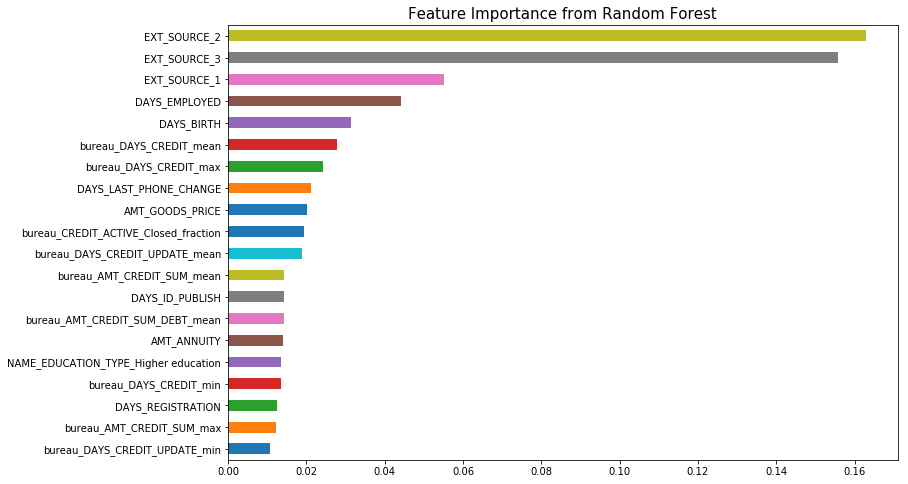

In [12]:
important_summary = important_summary.sort_values()
important_summary.plot(kind='barh', figsize=(12,8))
plt.title('Feature Importance from Random Forest', fontsize = 15);

The external credit agency scores appear to be the most important features by quite a large margin. Perhaps not surprising. It's interesting to note that nine of our engineered features appear in the top 20.

## Training Random Forest with Top 20 Important Attributes 

In [13]:
important_summary = RF_importances.sort_values(ascending=False)[0:20]
#clr = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), learning_rate = 1, n_estimators=300, random_state=777)
clr = RandomForestClassifier(max_depth=10, max_features=None, min_samples_leaf=10, n_estimators=500, n_jobs=-1, random_state=777)

# N.B. max_features below is set to 'None' rather than 32 because we're only using 20 attributes
metrics, matrix = classify_folds(clr, np.array(train_set[list(important_summary.index)]), np.array(train_labels), 'under', 10)

print('\nRandom Forest with top 20 important features only')
print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

0123456789
Random Forest with top 20 important features only

Confusion matrix from last fold:

Predicted      0     1
Actual                
0          13271  6510
1            576  1168

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.730740  0.652224   0.152650  0.247398  0.680898
1     0.736273  0.662987   0.152438  0.247882  0.678342
2     0.727922  0.660775   0.154143  0.249973  0.676902
3     0.745016  0.683070   0.156573  0.254752  0.683081
4     0.742975  0.690774   0.157165  0.256069  0.672582
5     0.742851  0.665483   0.154992  0.251426  0.689074
6     0.737392  0.669658   0.157749  0.255346  0.676484
7     0.736727  0.669658   0.159179  0.257217  0.679628
8     0.738397  0.684611   0.157810  0.256495  0.684878
9     0.723109  0.669725   0.152123  0.247930  0.670801
Mean  0.736140  0.670896   0.155482  0.252449  0.679267


Results are only slightly worse when using just the top 20 important attributes. Interestingly, run time is actually longer - not sure why this should be? In any case, managing 20 attributes would be significantly less work than managing 259 with no real drop in performance of the model.

<a id='ratio'></a>
# 6. Creating New Ratio Attributes
Here we will create some new attributes based on ratios of original attributes. The ratios chosen attempt to extract new relevant information to help in predicting defaulting applicants.

[Return](#toc)

In [17]:
# Reading in the original raw data after initial processing 
# and adding the engineered bureau attributes
path = 'C:/Users/X/Documents/A_Documents/Cap_Data/CSV'
df = pd.read_csv(path + '/app_with_features/app_features.csv')
print('Shape of df' + str(df.shape))

Shape of df(307511, 191)


In [18]:
# Ratios from app data
df['n_EXT_123'] = df[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].mean(axis=1)
df['n_EXT_12'] = df[['EXT_SOURCE_1','EXT_SOURCE_2']].mean(axis=1)
df['n_EXT_13'] = df[['EXT_SOURCE_1','EXT_SOURCE_3']].mean(axis=1)
df['n_EXT_23'] = df[['EXT_SOURCE_2','EXT_SOURCE_3']].mean(axis=1)
df['n_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['n_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['n_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['n_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['n_INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
df['n_INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
df['n_EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['n_ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
df['n_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['n_CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['n_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

In [20]:
# Ratios from bureau data
df['n_b_AMT_CREDIT_SUM_mean_to_INCOME'] = df['bureau_AMT_CREDIT_SUM_mean']/df['AMT_INCOME_TOTAL']
df['n_b_CREDIT_ACTIVE_Active_count_to_INCOME'] = df['bureau_CREDIT_ACTIVE_Active_count']/df['AMT_INCOME_TOTAL']
df['n_b_CREDIT_ACTIVE_Active_count_to_BIRTH'] = df['bureau_CREDIT_ACTIVE_Active_count']/df['DAYS_BIRTH']
df['n_b_CREDIT_ACTIVE_Active_fraction_to_INCOME'] = df['bureau_CREDIT_ACTIVE_Active_fraction']/df['AMT_INCOME_TOTAL']
df['n_b_CREDIT_ACTIVE_Active_fraction_to_BIRTH'] = df['bureau_CREDIT_ACTIVE_Active_fraction']/df['DAYS_BIRTH']
df['n_b_DAYS_CREDIT_mean_to_BIRTH'] = df['bureau_DAYS_CREDIT_mean']/df['DAYS_BIRTH']
df['n_b_DAYS_CREDIT_mean_to_EMPLOYED'] = df['bureau_DAYS_CREDIT_mean']/df['DAYS_EMPLOYED']

In [21]:
# new shape of the data
# 22 new attributes have been added
df.shape

(307511, 213)

In [ ]:
# Saving the dataframe with the new attributes to CSV file
# This file will now need to be run through the correlation analysis
# and test/train file creation
#df.to_csv(path + '/app_with_features/app_features_extra.csv', index=False)

<a id='ratio_test'></a>
# 7. Testing Performance with New Ratio Attributes

[Return](#toc)

In [8]:
# Reading in the data with the new ratio attributes after correlation 
# analysis and train/test creation
path = 'C:/Users/X/Documents/A_Documents/Cap_Data/CSV'
train_set = pd.read_csv(path + '/train_test_sets/train_set_std_extras.csv')
train_labels = pd.read_csv(path + '/train_test_sets/train_labels_extras.csv')

In [9]:
train_set.shape

(215257, 275)

<a id='test_lr'></a>
## A. Logistic Regression

[Return](#toc)

In [30]:
# Training Logistic Regression on the new data with ratio attributes
clr = LogisticRegression(C=0.001, penalty='l1')

metrics, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'under', 10)

print('\nResults from data with new ratio attributes:')
print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

# saving results
metrics.to_csv(path+'/results/LR_extras.csv')

0123456789
Results from data with new ratio attributes:

Confusion matrix from last fold:

Predicted      0     1
Actual                
0          11926  7855
1            504  1240

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.717854  0.716927   0.135970  0.228587  0.610889
1     0.724595  0.721092   0.136434  0.229454  0.612794
2     0.719391  0.717218   0.139592  0.233699  0.616743
3     0.731961  0.739895   0.137988  0.232597  0.612840
4     0.729840  0.731777   0.139371  0.234147  0.609495
5     0.730794  0.725281   0.135704  0.228630  0.615999
6     0.728327  0.729669   0.142139  0.237930  0.612840
7     0.726683  0.730230   0.142140  0.237960  0.612590
8     0.729675  0.730252   0.138053  0.232208  0.616585
9     0.712678  0.711009   0.136339  0.228803  0.611661
Mean  0.725180  0.725335   0.138373  0.232401  0.613244


<a id='test_rf'></a>
## B. Random Forest

[Return](#toc)

In [31]:
# Training Random Forest on the new data with ratio attributes
clr = RandomForestClassifier(max_depth=10, max_features=32, min_samples_leaf=10, n_estimators=500, n_jobs=-1, random_state=777)
metrics, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'under', 10)

print('\nResults from data with new ratio attributes:')
print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

# saving results
metrics.to_csv(path+'/results/RF_extras.csv')

0123456789
Results from data with new ratio attributes:

Confusion matrix from last fold:

Predicted      0     1
Actual                
0          13662  6119
1            597  1147

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.743479  0.675332   0.159373  0.257887  0.687448
1     0.749540  0.665892   0.157396  0.254610  0.688284
2     0.743745  0.664766   0.160341  0.258365  0.689027
3     0.760190  0.698301   0.164664  0.266488  0.695159
4     0.750257  0.686788   0.164462  0.265376  0.689817
5     0.755301  0.677324   0.162293  0.261845  0.700362
6     0.749648  0.676388   0.164844  0.265084  0.689352
7     0.748159  0.678071   0.163977  0.264089  0.686969
8     0.749881  0.681685   0.161738  0.261445  0.694216
9     0.735180  0.657683   0.157859  0.254606  0.687991
Mean  0.748538  0.676223   0.161695  0.260979  0.690863


<a id='test_ada'></a>
## C. AdaBoost

[Return](#toc)

In [32]:
# Training AdaBoost on the new data with ratio attributes
clr = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), learning_rate = 1, n_estimators=300, random_state=777)
metrics, matrix = classify_folds(clr, np.array(train_set), np.array(train_labels), 'under', 10)

print('Results from data with new ratio attributes:')
print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

# saving results
metrics.to_csv(path+'/results/ADA_extras.csv')

0123456789Results from data with new ratio attributes:

Confusion matrix from last fold:

Predicted      0     1
Actual                
0          13875  5906
1            565  1179

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.749100  0.678221   0.161352  0.260686  0.690653
1     0.757913  0.686810   0.164831  0.265857  0.696739
2     0.753053  0.674458   0.167090  0.267829  0.699526
3     0.768755  0.700059   0.169937  0.273487  0.705054
4     0.760138  0.683941   0.167177  0.268680  0.696274
5     0.755629  0.674364   0.161974  0.261209  0.700688
6     0.756021  0.688727   0.171413  0.274505  0.698458
7     0.755910  0.691531   0.168974  0.271586  0.692729
8     0.760200  0.682270   0.165109  0.265876  0.700859
9     0.746550  0.676032   0.166408  0.267074  0.699373
Mean  0.756327  0.683641   0.166426  0.267679  0.698035


<a id='summary'></a>
## D. Summary of Results

[Return](#toc)

In [27]:
# Read in the original results before the ratio attributes were added
tuned_summary = pd.read_csv(path+'/results/tuned_summary.csv',index_col=0)
tuned_summary.insert(loc=0, column='Ratio_Attributes', value='No')

In [25]:
# Creating a summary dataframe from saved ratio test results
ratio_summary = pd.read_csv(path + '/results/LR_extras.csv', index_col=0).loc[['Mean'],:]
ratio_summary = ratio_summary.append(pd.read_csv(path + '/results/RF_extras.csv', index_col=0).loc[['Mean'],:])
ratio_summary = ratio_summary.append(pd.read_csv(path + '/results/ADA_extras.csv', index_col=0).loc[['Mean'],:])
ratio_summary.index=['Logistic Regression', 'Random Forest', 'AdaBoost']
ratio_summary.insert(loc=0, column='Ratio_Attributes', value='Yes')
# Saving ratio summary
ratio_summary.to_csv(path+'/results/ratio_summary.csv')

In [28]:
# Creating a final summary dataframe with all results and saving
final_summary = ratio_summary.append(tuned_summary).sort_index()
# Saving final summary
final_summary.to_csv(path+'/results/final_summary.csv')

In [30]:
print('Summary of results with and without Ratio Attributes:')
final_summary

Summary of results with and without Ratio Attributes:


,Ratio_Attributes,ROC_AUC,Recall,Precision,F1-Score,Accuracy
AdaBoost,Yes,0.756327,0.683641,0.166426,0.267679,0.698035
AdaBoost,No,0.750388,0.679599,0.163093,0.263047,0.692637
Logistic Regression,Yes,0.725180,0.725335,0.138373,0.232401,0.613244
Logistic Regression,No,0.721779,0.725579,0.135938,0.228970,0.605565
Random Forest,Yes,0.748538,0.676223,0.161695,0.260979,0.690863
Random Forest,No,0.744967,0.682176,0.159073,0.257980,0.683230


Logistic Regression and Random Forest saw improvements in all metrics except Recall where there was a small drop. In particular, both models saw improvements in the F1-Score and ROC_AUC.

AdaBoost saw improvements in all metrics and has the highest ROC_AUC and F1-Score among the three models.

In [6]:
# A table used in 'Disucssion of Results' in final report
final_summary = pd.read_csv(path+'/results/final_summary.csv',index_col=0)
final_summary[final_summary['Ratio_Attributes']=='Yes'].sort_values('ROC_AUC')

,Ratio_Attributes,ROC_AUC,Recall,Precision,F1-Score,Accuracy
Logistic Regression,Yes,0.725180,0.725335,0.138373,0.232401,0.613244
Random Forest,Yes,0.748538,0.676223,0.161695,0.260979,0.690863
AdaBoost,Yes,0.756327,0.683641,0.166426,0.267679,0.698035


<a id='signif'></a>
## E. Testing for Significant Difference in Results
Here we will test for a significant difference in the results between the original data set and the data set with the new ratio attributes. We will consider the results from the AdaBoost model only.

[Return](#toc)

In [4]:
# Reading results 
path = 'C:/Users/X/Documents/A_Documents/Cap_Data/CSV'
orig = pd.read_csv(path+'/results/AdaBoost_best_params.csv', index_col=0).drop(['Mean'],axis=0)
orig['Source']='ADA_Original'
ratio = pd.read_csv(path+'/results/ADA_extras.csv', index_col=0).drop(['Mean'],axis=0)
ratio['Source']='ADA_Ratios'

#Creating combined dataframe and renaming one column
data = orig.append(ratio)
data = data.rename(columns={'F1-Score': 'F1Score'})

data

,ROC_AUC,Recall,Precision,F1Score,Accuracy,Source
0,0.744750,0.688042,0.162572,0.263001,0.689910,ADA_Original
1,0.757162,0.694364,0.163766,0.265026,0.692093,ADA_Original
2,0.746221,0.656784,0.160984,0.258586,0.693115,ADA_Original
3,0.762547,0.694200,0.166269,0.268282,0.699712,ADA_Original
4,0.752650,0.679385,0.163469,0.263530,0.690235,ADA_Original
5,0.751915,0.678508,0.160123,0.259100,0.695531,ADA_Original
6,0.750328,0.677510,0.167522,0.268624,0.694416,ADA_Original
7,0.747073,0.679192,0.164159,0.264410,0.686969,ADA_Original
8,0.754553,0.683441,0.163015,0.263241,0.696260,ADA_Original
9,0.736677,0.664564,0.159050,0.256671,0.688130,ADA_Original


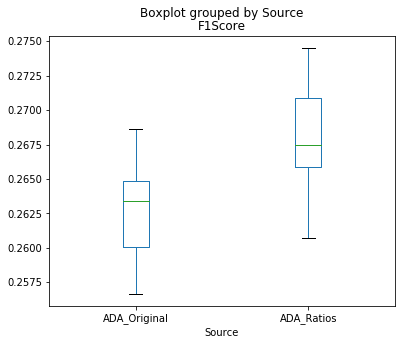

In [8]:
data.boxplot('F1Score', by='Source', figsize=(6,5), grid=False);

In [7]:
# Testing metrics using paired t-test
from scipy import stats

def sig_test(var, typ):
    
    X = data[data['Source']=='ADA_Ratios'][var]
    Y = data[data['Source']=='ADA_Original'][var]
    
    # t-test for two indpendent samples
    # print(stats.ttest_ind(one,two, equal_var=True))

    # Paired test
    # test stat from X-Y, two tailed test by default
    # Right tailed (X-Y)>0, test-stat>0 then p-value becomes p-value/2
    #                       test-stat<0 then p-value becomes 1-p-value/2
    # Left tailed (X-Y)<0,  test-stat>0 then p=value becomes 1-p-value/2
    #                       test-stat<0 then p=value becomes p-value/2 
    
    # H0: Mean of <metric> from ADA_Ratios =< mean of <metric> from ADA_Original
    # Ha: Mean of <metric> from ADA_Ratios  > mean of <metric> from ADA_Original
        
    # t-test for paired samples
    stat, p = stats.ttest_rel(X,Y)
    if typ=='greater' and stat>0:
        return (stat, p/2)
    if typ=='greater' and stat<0:
        return (stat, 1-p/2)
    if typ=='lower' and stat>0:
        return (stat, 1-p/2)
    if typ=='lower' and stat<0:
        return (stat, p/2)
    if typ=='different':
        return (stat, p)

print("Recall test:")
stat, p = sig_test('Recall', 'greater')
print('t-statistic {:.4f}, p-value: {:.6f}'.format(stat,p))

print("\nPrecision test:")
stat, p = sig_test('Precision', 'greater')
print('t-statistic {:.4f}, p-value: {:.6f}'.format(stat,p))

print("\nF1Score test:")
stat, p = sig_test('F1Score', 'greater')
print('t-statistic {:.4f}, p-value: {:.6f}'.format(stat,p))

print("\nROC_AUC test:")
stat, p = sig_test('ROC_AUC', 'greater')
print('t-statistic {:.4f}, p-value: {:.6f}'.format(stat,p))

print("\nAccuracy test:")
stat, p = sig_test('Accuracy', 'greater')
print('t-statistic {:.4f}, p-value: {:.6f}'.format(stat,p))

Recall test:
t-statistic 1.3681, p-value: 0.102231

Precision test:
t-statistic 4.2168, p-value: 0.001125

F1Score test:
t-statistic 3.7645, p-value: 0.002227

ROC_AUC test:
t-statistic 7.1739, p-value: 0.000026

Accuracy test:
t-statistic 6.5840, p-value: 0.000051


With the exception of Recall, all the metrics have seen a statistically significant improvement after adding the new ratio attributes.

In [115]:
# Quick check to ensure that Recall is not statistically different
print("Recall test:")
stat, p = sig_test('Recall', 'different')
print('t-statistic {:.4f}, p-value: {:.6f}'.format(stat,p))

Recall test:
t-statistic 1.3681, p-value: 0.204462


There has been no statistically significant change in Recall after adding the new ratio attributes. This is a good result given the improvements in all the other metrics. The new attributes have helped reduce the false positives (as shown by the improved precision).

<a id='ensemble'></a>
# 8. Building an Ensemble Voting Classifier Model
Here we will test if an ensemble voting classifier built from our three models above can outperfrom the individual models.

[Return](#toc)

<a id='soft'></a>
## A. Ensemble - Soft Voting

[Return](#toc)

In [10]:
# Creating an ensemble model from our three models.
from sklearn.ensemble import VotingClassifier

# The three models using our tuned hyperparameters
c1 = LogisticRegression(C=0.001, penalty='l1')
c2 = RandomForestClassifier(max_depth=10, max_features=32, min_samples_leaf=10, n_estimators=500, n_jobs=-1, random_state=777)
c3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), learning_rate = 1, n_estimators=300, random_state=777)

# Using 'soft' voting were class probabilities are the average of the probabilities from each model
eclf = VotingClassifier(estimators=[('lr', c1), ('rf', c2), ('ada', c3)], voting='soft', n_jobs=-1)

metrics, matrix = classify_folds(eclf, np.array(train_set), np.array(train_labels), 'under', 10)

# saving results
metrics.to_csv(path+'/results/ensemble_soft_extras.csv')

print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)


0123456789
Confusion matrix from last fold:

Predicted      0     1
Actual                
0          13062  6719
1            557  1187

Cross validation results

       ROC_AUC    Recall  Precision  F1-Score  Accuracy
0     0.736170  0.686308   0.149472  0.245480  0.660736
1     0.742115  0.688553   0.149395  0.245520  0.661665
2     0.736633  0.689852   0.154297  0.252188  0.666636
3     0.751126  0.717633   0.154011  0.253597  0.665010
4     0.744984  0.695900   0.153210  0.251130  0.661433
5     0.748404  0.699230   0.152367  0.250212  0.671188
6     0.743732  0.700505   0.156910  0.256389  0.663430
7     0.742114  0.707796   0.156576  0.256426  0.659977
8     0.744801  0.699824   0.152434  0.250340  0.667224
9     0.728804  0.680619   0.150139  0.246010  0.661974
Mean  0.741888  0.696622   0.152881  0.250729  0.663927


The soft voting ensemble model doesn't outperform Random Forest or AdadBoost based on the F1-Score.

<a id='hard'></a>
## B. Ensemble - Hard Voting

[Return](#toc)

In [11]:
# A function to perform cross validation 
# with three different choices of sampling method
# The ROC curve plot has been commented out below. Not required here.
# The probability functions have been commented out to allow for 'hard' voting in ensemble model

def classify_folds_NoProb(clr, train_x, train_y, sample_method, folds):
    
    # Lists to store metrics
    #aucs=[]
    recall=[]
    precision=[]
    f1score=[]
    accuracy=[]

    # Create the random under & over samplers
    rus = RandomUnderSampler(random_state=777)
    smote = SMOTE(ratio='minority', random_state=777, n_jobs=-1)

    # Create the folds
    splits = KFold(n_splits=folds).split(train_x, train_y)

    #fig = plt.figure(figsize=(8,6))
    i=0
    
    # Iterate through the folds
    for train_fold, test_fold in splits:
        # Depending on choice of sampling method - execute sampling
        if sample_method == 'under':
            sampled_x, sampled_y = rus.fit_sample(train_x[train_fold], train_y[train_fold])
        elif sample_method == 'over':
            sampled_x, sampled_y = smote.fit_sample(train_x[train_fold], train_y[train_fold])
        elif sample_method == 'none':
            sampled_x, sampled_y = train_x[train_fold], train_y[train_fold]            
        else:
            print('Incorrect Sample Input')
            return
    
        # Train the classifier on the sampled data
        clr.fit(sampled_x, sampled_y)
    
        # Test the classifier on the test fold (which is not sampled and remains imbalanced)
        #probs = clr.predict_proba(train_x[test_fold])
        predict = clr.predict(train_x[test_fold])
        
        # Return arrays containing the fpr (x-axis), tpr (y-axis) and thresholds
        #fpr, tpr, thresholds = roc_curve(train_y[test_fold], probs[:, 1])
    
        # Compute area under ROC curve
        #roc_auc = auc(fpr, tpr)
    
        # Plot ROC curve
        #plt.plot(fpr, tpr, lw=1, alpha=0.8, label='Fold %d (AUC = %0.2f)' % (i, roc_auc))
    
        # Generate confusion matrix, compute measures and store
        matrix = confusion_matrix(train_y[test_fold], predict)
        TP = matrix[1,1]
        TN = matrix[0,0]
        FP = matrix[0,1]
        FN = matrix[1,0]
        rec = TP/(TP+FN)
        prec = TP/(TP+FP)
        f1 = 2*prec*rec/(prec+rec)
        acc = (TP+TN) /(TP+TN+FP+FN)
    
        #aucs.append(roc_auc)
        recall.append(rec)
        precision.append(prec)
        f1score.append(f1)
        accuracy.append(acc)
        print(i,end="")
        i += 1
    
    #plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    #plt.xlabel('False Positive Rate', fontsize=15)
    #plt.ylabel('True Positive Rate', fontsize=15)
    #plt.title('ROC Curves', fontsize=15)
    #plt.legend(loc='lower right'); 

    # Dataframes to return results
    matrix = pd.DataFrame(matrix)
    matrix.index.name = 'Actual'; matrix.columns.name = 'Predicted'
    #results = pd.DataFrame({'ROC_AUC':aucs, 'Recall':recall, 'Precision':precision, 'F1-Score':f1score, 'Accuracy':accuracy})
    results = pd.DataFrame({'Recall':recall, 'Precision':precision, 'F1-Score':f1score, 'Accuracy':accuracy})
    mean = results.mean(); mean.name = 'Mean'
    #return results.append(mean), fig, matrix
    return results.append(mean), matrix

In [13]:
# Creating an ensemble model from our three models.
from sklearn.ensemble import VotingClassifier

# The three models using our tuned hyperparameters
c1 = LogisticRegression(C=0.001, penalty='l1')
c2 = RandomForestClassifier(max_depth=10, max_features=32, min_samples_leaf=10, n_estimators=500, n_jobs=-1, random_state=777)
c3 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), learning_rate = 1, n_estimators=300, random_state=777)

# Using 'hard' voting were classes are assigned based on a majority vote
eclf = VotingClassifier(estimators=[('lr', c1), ('rf', c2), ('ada', c3)], voting='hard', n_jobs=-1)

metrics, matrix = classify_folds_NoProb(eclf, np.array(train_set), np.array(train_labels), 'under', 10)

# saving results
metrics.to_csv(path+'/results/ensemble_hard_extras.csv')

print('\nConfusion matrix from last fold:\n'); print(matrix)
print('\nCross validation results\n'); print(metrics)

0123456789
Confusion matrix from last fold:

Predicted      0     1
Actual                
0          13340  6441
1            555  1189

Cross validation results

        Recall  Precision  F1-Score  Accuracy
0     0.694974   0.154886  0.253316  0.670538
1     0.694364   0.154913  0.253312  0.672721
2     0.683580   0.157514  0.256032  0.676298
3     0.719977   0.160612  0.262635  0.679411
4     0.702733   0.159824  0.260420  0.674394
5     0.695086   0.156784  0.255857  0.682756
6     0.696579   0.161593  0.262330  0.675509
7     0.699383   0.160015  0.260443  0.670987
8     0.703335   0.158492  0.258689  0.679954
9     0.681766   0.155832  0.253680  0.674983
Mean  0.697178   0.158047  0.257672  0.675755


As above, the hard voting ensemble method doesn't outperform Random Forest or AdaBoost based on the F1-Score.

<a id='ensemble_summary'></a>
## C. Summary Results with Ensemble Models

[Return](#toc)

In [7]:
# Reading in data
path = 'C:/Users/X/Documents/A_Documents/Cap_Data/CSV'
final_summary = pd.read_csv(path+'/results/final_summary.csv', index_col=0)
final_summary = final_summary.loc[final_summary['Ratio_Attributes']=='Yes', ]
soft = pd.read_csv(path + '/results/ensemble_soft_extras.csv', index_col=0).loc[['Mean'],:]
soft['Ratio_Attributes']='Yes'
soft.index=['Ensemble_Soft_Voting']
hard = pd.read_csv(path + '/results/ensemble_hard_extras.csv', index_col=0).loc[['Mean'],:]
hard['Ratio_Attributes']='Yes'
hard.index=['Ensemble_Hard_Voting']

In [9]:
# Creating an expanded summary to include the ensemble results
ens_summary = final_summary.append(soft).append(hard)[list(final_summary.columns)]
# Saving summary
ens_summary.to_csv(path+'/results/ens_summary_extras_2.csv')
print('Summary Results:')
ens_summary

Summary Results:


,Ratio_Attributes,ROC_AUC,Recall,Precision,F1-Score,Accuracy
AdaBoost,Yes,0.756327,0.683641,0.166426,0.267679,0.698035
Logistic Regression,Yes,0.725180,0.725335,0.138373,0.232401,0.613244
Random Forest,Yes,0.748538,0.676223,0.161695,0.260979,0.690863
Ensemble_Soft_Voting,Yes,0.741888,0.696622,0.152881,0.250729,0.663927
Ensemble_Hard_Voting,Yes,NaN,0.697178,0.158047,0.257672,0.675755
